In [1]:
! chmod 600 /content/kaggle.json

In [17]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d mmoreaux/audio-cats-and-dogs

 97% 94.0M/97.0M [00:00<00:00, 92.1MB/s]
100% 97.0M/97.0M [00:00<00:00, 111MB/s] 


In [18]:
!mkdir /content/CatDog

In [19]:
import zipfile
zip_file = zipfile.ZipFile('/content/audio-cats-and-dogs.zip')
zip_file.extractall('/content/CatDog')

In [5]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [20]:
data_dir = pathlib.Path('/content/CatDog/cats_dogs/train')
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['dog' 'cat']


In [21]:
filenames = tf.io.gfile.glob(str(data_dir)+ '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:', 
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 210
Number of examples per label: 85
Example file tensor: tf.Tensor(b'/content/CatDog/cats_dogs/train/cat/cat_41.wav', shape=(), dtype=string)


In [22]:
train_files = filenames[:100]
val_files = filenames[150:150+60]
test_files = filenames[-50:]

In [23]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2]

def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

In [37]:
def get_spectrogram(waveform):
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=25, frame_step=8)
  spectrogram = tf.abs(spectrogram)
  return spectrogram

def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

InvalidArgumentError: ignored

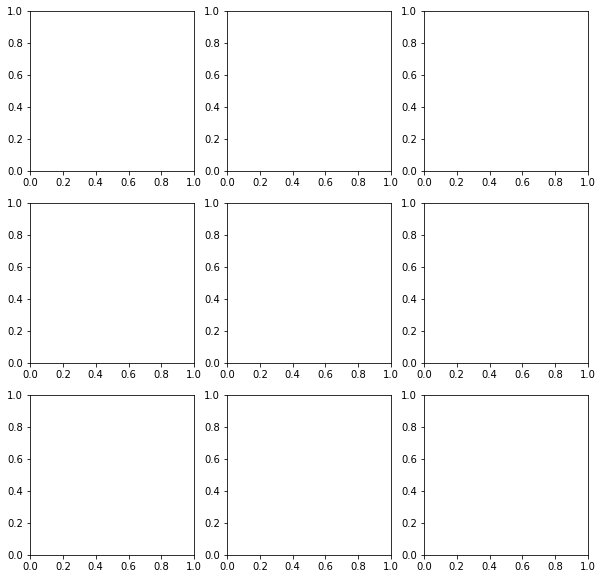

In [38]:
def plot_spectrogram(spectrogram, ax):
  log_spec = np.log( spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()